In [91]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [92]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
words[:10]

32033
15


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [93]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
c_to_i = {c: i+1 for i, c in enumerate(chars)}
c_to_i['.'] = 0
i_to_c = {i: c for c, i in c_to_i.items()}
vocab_size = len(i_to_c)

In [94]:
# shuffle up the words
random.seed(42)
random.shuffle(words)

In [95]:
# Number of inputs prior to target character
BLOCK_SIZE = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE

        for ch in w + '.':
            target_idx = c_to_i[ch]
            X.append(context)
            Y.append(target_idx)

            # Slide context window over to next set of chars
            context = context[1:] + [target_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# build dataset & train/test/validation split
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [96]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(i_to_c[ix.item()] for ix in x), '--->', i_to_c[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [103]:
# Create layers to build model
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # Set training flag
        self.training = True

        # Initialize training parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Initialize buffers
        self.mean = torch.zeros(dim)
        self.var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
                
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.mean
            xvar = self.var
        
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # Update buffers
        if self.training:
            with torch.no_grad():
                self.mean = (1 - self.momentum) * self.mean + self.momentum * xmean
                self.var = (1 - self.momentum) * self.var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [104]:
# seed rng
torch.manual_seed(42)

In [113]:
# Set hyper parameters
EMBEDDING_DIM = 24
INPUT_DIM = BLOCK_SIZE * EMBEDDING_DIM
HIDDEN_DIM = 128

# Create model
model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM),
    FlattenConsecutive(2), Linear(EMBEDDING_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    FlattenConsecutive(2), Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    FlattenConsecutive(2), Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, vocab_size)
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [114]:
# Grab 4 random examples to check model
ix = torch.randint(0, X_train.shape[0], (4,))
X_b, Y_b = X_train[ix], Y_train[ix]
logits = model(X_b)

for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [115]:
# Training loop
n_iter = 200000
batch_size = 32
losses = []

for i in range(n_iter):
    # minibatching
    ixs = torch.randint(0, X_train.shape[0], (batch_size,))
    x_batch, y_batch = X_train[ixs], Y_train[ixs]

    # Forward pass
    logits = model(x_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0 or i == n_iter - 1:
        print(f'{i:7d}/{n_iter - 1:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

      0/ 199999: 3.4191
  10000/ 199999: 1.9597
  20000/ 199999: 1.9828
  30000/ 199999: 1.8847
  40000/ 199999: 1.8838
  50000/ 199999: 2.0015
  60000/ 199999: 2.1989
  70000/ 199999: 1.7240
  80000/ 199999: 2.0121
  90000/ 199999: 2.0879
 100000/ 199999: 1.8503
 110000/ 199999: 2.1979
 120000/ 199999: 2.0661
 130000/ 199999: 2.2988
 140000/ 199999: 1.8350
 150000/ 199999: 1.7871
 160000/ 199999: 1.5410
 170000/ 199999: 1.9475
 180000/ 199999: 1.6456
 190000/ 199999: 1.9212
 199999/ 199999: 1.5146


torch.Size([200, 1000])


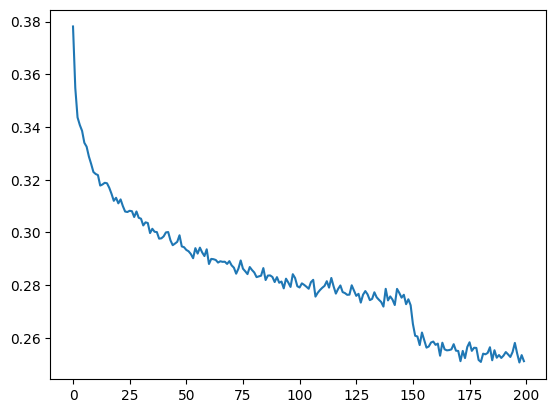

In [116]:
# Reshape losses into groups of 1000
# Average groups to smooth loss chart
losses_reshaped = torch.tensor(losses).view(-1, 1000)
print(losses_reshaped.shape)
losses_avgd = losses_reshaped.mean(1)
plt.plot(losses_avgd)

In [117]:
for layer in model.layers:
    layer.training = False

In [118]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7699744701385498
val 1.9875609874725342


In [45]:
# Generate names
def generate_names(n):
    for _ in range(n):
        out = []

        context = [0] * BLOCK_SIZE
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits , dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        
        print(''.join(i_to_c[i] for i in out))

In [46]:
generate_names(12)

samyali.
naveria.
brik.
jose.
jyever.
iden.
lenet.
oak.
eim.
anni.
armelani.
trius.
